### GAN with least square adversarial loss

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import random
import time
from models.models_v2 import ConvLSTM, PhyCell, EncoderRNN
#from data.moving_mnist import MovingMNIST
from constrain_moments import K2M
#from skimage.measure import compare_ssim as ssim
from skimage.metrics import structural_similarity as ssim
import os
#import argparse
import h5py
import torch.utils.data as data
import math
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import datetime
import itertools

#### create the training, validation set for PhyDNet model testing on Sky image dataset

In [2]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):
    
    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [3]:
# Spliting the dayblock shuffled indices into training and validation
def trainval_split(split_data, split_ratio):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data[0])
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[:int(split_ratio * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(0)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    # Initialize the training and validation data set list
    data_train = []
    data_val = []
    # obtain training and validation data
    for one_data in split_data:
        one_train, one_val = one_data[train_indices], one_data[val_indices]
        data_train.append(one_train)
        data_val.append(one_val)

    return data_train,data_val

In [4]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data',"dataset_all")
data_path = os.path.join(data_folder,'video_prediction_dataset.hdf5')
print("data_folder:", data_folder)
print("data_path:", data_path)

data_folder: /scratch/groups/abrandt/GAN_project/data/dataset_all
data_path: /scratch/groups/abrandt/GAN_project/data/dataset_all/video_prediction_dataset.hdf5


In [ ]:
with h5py.File(data_path,'r') as f:
    trainval = f['trainval']
    images_log_train = trainval['images_log'][...][:,::2,:,:,:]
    images_pred_train = trainval['images_pred'][...][:,::2,:,:,:]
    
    test = f['test']
    images_log_test = test['images_log'][...][:,::2,:,:,:]
    images_pred_test = test['images_pred'][...][:,::2,:,:,:]

times_curr_train = np.load(os.path.join(data_folder,"times_curr_trainval.npy"),allow_pickle=True)
times_curr_test = np.load(os.path.join(data_folder,"times_curr_test.npy"),allow_pickle=True)
print('-'*50)
print("times_curr_train.shape:", times_curr_train.shape)
print("images_log_train.shape:", images_log_train.shape)
print("images_pred_train.shape:", images_pred_train.shape) 
print("times_curr_test.shape:", times_curr_test.shape)
print("images_log_test.shape:", images_log_test.shape)
print("images_pred_test.shape:", images_pred_test.shape)
print('-'*50)
# get the input dimension for constructing the model
num_log_frame = images_log_train.shape[1]
img_side_len = images_log_train.shape[2]
num_color_channel = images_log_train.shape[4]
num_pred_frame = images_pred_train.shape[1]
image_log_dim = [num_log_frame,img_side_len,img_side_len,num_color_channel]
image_pred_dim = [num_pred_frame,img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of log frames:", num_log_frame)
print("number of pred frames:", num_pred_frame)
print("number of color channels:", num_color_channel)
print("context(log) image dimension:", image_log_dim)
print("future(pred) image dimension:", image_pred_dim)

#shuffled_indices = day_block_shuffle(times_curr_train)
#times_curr_train = times_curr_train[shuffled_indices]
#images_log_train = images_log_train[shuffled_indices]
#images_pred_train = images_pred_train[shuffled_indices]

#split_ratio = 0
#split_data = [times_curr_trainval,images_log_trainval,images_pred_trainval]

#data_train, data_test = trainval_split(split_data, split_ratio)

#times_curr_train, images_log_train, images_pred_train = data_train[0], data_train[1], data_train[2] 

In [5]:
with h5py.File(data_path,'r') as f:
    
    test = f['test']
    images_log_test = test['images_log'][...][:,::2,:,:,:]
    images_pred_test = test['images_pred'][...][:,::2,:,:,:]

times_curr_test = np.load(os.path.join(data_folder,"times_curr_test.npy"),allow_pickle=True)
print("times_curr_test.shape:", times_curr_test.shape)
print("images_log_test.shape:", images_log_test.shape)
print("images_pred_test.shape:", images_pred_test.shape)

times_curr_test.shape: (4467,)
images_log_test.shape: (4467, 8, 64, 64, 3)
images_pred_test.shape: (4467, 8, 64, 64, 3)


In [13]:
# get the input dimension for constructing the model
num_log_frame = images_log_test.shape[1]
img_side_len = images_log_test.shape[2]
num_color_channel = images_log_test.shape[4]
num_pred_frame = images_pred_test.shape[1]
image_log_dim = [num_log_frame,img_side_len,img_side_len,num_color_channel]
image_pred_dim = [num_pred_frame,img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of log frames:", num_log_frame)
print("number of pred frames:", num_pred_frame)
print("number of color channels:", num_color_channel)
print("context(log) image dimension:", image_log_dim)
print("future(pred) image dimension:", image_pred_dim)

image side length: 64
number of log frames: 8
number of pred frames: 8
number of color channels: 3
context(log) image dimension: [8, 64, 64, 3]
future(pred) image dimension: [8, 64, 64, 3]


### dataloader

In [6]:
class SkyImageDataset(data.Dataset):
    #def __init__(self, data, is_train=True, n_frames_input=16, n_frames_output=15, transform=None):
    def __init__(self, data_set, transform=None):
        #self.is_train = is_train
        #self.n_frames_input = n_frames_input
        #self.n_frames_output = n_frames_output
        #self.n_frames_total = self.n_frames_input + self.n_frames_output
        self.data_set = data_set
        self.transform = transform
        self.length = self.data_set[0].shape[0]
        
    def __getitem__(self, idx):
        input_data = self.data_set[0][idx]
        output_data = self.data_set[1][idx]
        length = len(input_data)
        input_data = input_data.transpose(0, 3, 1, 2)
        output_data = output_data.transpose(0, 3, 1, 2)
        
        output_data = torch.from_numpy(output_data / 255.0).contiguous().float()
        input_data = torch.from_numpy(input_data / 255.0).contiguous().float()
        # print()
        #print(input.size())
        #print(output.size())

        out = [idx,input_data,output_data]
        return out

    def __len__(self):
        return self.length


### Discriminator architecture

In [7]:
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of feature maps in discriminator
ndf = 16

# Frame discriminator 
class Discr_frame(torch.nn.Module):
    def __init__(self):
        super(Discr_frame, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(0.2),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(0.2),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, ndf * 16, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Linear(ndf * 16, 1)
            #nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### Training and Validate the Model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()
data_folder = os.path.join(cwd,"data") 
batch_size = 16
nepochs = 50
print_every = 1
eval_every = 5
plot_every = 1*eval_every
save_model_every = 1
save_name = 'PhyDNet_LSGAN_sky_image_dataset_gen_lr_0.001_batch_size_16_model_v2_scheduled_and_reverse_scheduled_sampling_MAE_loss_all_data_v3'
if not os.path.isdir('save/{}'.format(save_name)):
    os.mkdir('save/{}'.format(save_name))
lamda = 0.01 # weight for generator adversarial loss
training_discriminator_every=1

In [ ]:
data_set = SkyImageDataset([images_log_train, images_pred_train])
train_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True, num_workers=0)

data_set = SkyImageDataset([images_log_test, images_pred_test])
test_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [9]:
constraints = torch.zeros((49,7,7)).to(device)
ind = 0
for i in range(0,7):
    for j in range(0,7):
        constraints[ind,i,j] = 1
        ind +=1 

In [10]:
def plot_gen_images(predictions,times_curr,images_log,images_pred,select_idx):
    predictions = predictions.transpose((0,1,3,4,2))
    for i in range(len(select_idx)):
        #print("-"*50,"sample ",str(i+1), "-"*50)
        f, ax = plt.subplots(2,8)
        f.subplots_adjust(wspace=0, hspace=0)
        f.set_size_inches(24,6)
        ax[0,0].imshow(images_log[select_idx[i]][0][:,:,::-1])
        ax[0,0].set_title(times_curr[select_idx[i]]-datetime.timedelta(minutes=14))
        ax[0,1].imshow(images_log[select_idx[i]][2][:,:,::-1])
        ax[0,1].set_title(times_curr[select_idx[i]]-datetime.timedelta(minutes=10))
        ax[0,2].imshow(images_log[select_idx[i]][4][:,:,::-1])
        ax[0,2].set_title(times_curr[select_idx[i]]-datetime.timedelta(minutes=6))
        ax[0,3].imshow(images_log[select_idx[i]][7][:,:,::-1])
        ax[0,3].set_title(times_curr[select_idx[i]])
        ax[0,4].imshow(images_pred[select_idx[i]][0][:,:,::-1])
        ax[0,4].set_title(times_curr[select_idx[i]]+datetime.timedelta(minutes=1))
        ax[0,5].imshow(images_pred[select_idx[i]][2][:,:,::-1])
        ax[0,5].set_title(times_curr[select_idx[i]]+datetime.timedelta(minutes=5))
        ax[0,6].imshow(images_pred[select_idx[i]][4][:,:,::-1])
        ax[0,6].set_title(times_curr[select_idx[i]]+datetime.timedelta(minutes=9))
        ax[0,7].imshow(images_pred[select_idx[i]][7][:,:,::-1])
        ax[0,7].set_title(times_curr[select_idx[i]]+datetime.timedelta(minutes=15))

        ax[1,4].imshow(predictions[select_idx[i]][0][:,:,::-1])
        ax[1,5].imshow(predictions[select_idx[i]][2][:,:,::-1])
        ax[1,6].imshow(predictions[select_idx[i]][4][:,:,::-1])
        ax[1,7].imshow(predictions[select_idx[i]][7][:,:,::-1])

        ax[0,0].axis('off')
        ax[0,1].axis('off')
        ax[0,2].axis('off')
        ax[0,3].axis('off')
        ax[0,4].axis('off')
        ax[0,5].axis('off')
        ax[0,6].axis('off')
        ax[0,7].axis('off')
        ax[1,0].axis('off')
        ax[1,1].axis('off')
        ax[1,2].axis('off')
        ax[1,3].axis('off')
        ax[1,4].axis('off')
        ax[1,5].axis('off')
        ax[1,6].axis('off')
        ax[1,7].axis('off')

        plt.show()

In [11]:
sampling_step_1 = 15
sampling_step_2 = 30
r_exp_alpha = 2.5

def reserve_schedule_sampling_exp(epoch, log_length):
    real_input_flag_encoder = np.zeros(log_length, dtype=bool)
    if epoch < sampling_step_1:
        r_eta = 0.5
    elif epoch < sampling_step_2:
        r_eta = 1.0 - 0.5 * math.exp(-float(epoch - sampling_step_1) / r_exp_alpha)
    else:
        r_eta = 1.0
    for i in range(log_length):
        real_input_flag_encoder[i] = True if random.random() < r_eta else False
    return r_eta, real_input_flag_encoder

def schedule_sampling(epoch,pred_length):
    real_input_flag_decoder = np.zeros(pred_length, dtype=bool)
    if epoch < sampling_step_1:
        eta = 0.5
    elif epoch < sampling_step_2:
        eta = 0.5 - (0.5 / (sampling_step_2 - sampling_step_1)) * (epoch - sampling_step_1)
    else:
        eta = 0
    for i in range(pred_length):
        real_input_flag_decoder[i] = True if random.random() < eta else False
    return eta, real_input_flag_decoder

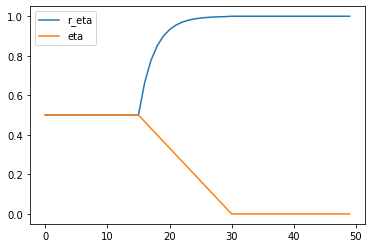

In [14]:
r_eta = np.zeros(nepochs)
eta = np.zeros(nepochs)
for epoch in range(nepochs):
    r_eta[epoch],real_input_flag_encoder = reserve_schedule_sampling_exp(epoch,num_log_frame)
    eta[epoch],real_input_flag_decoder = schedule_sampling(epoch,num_pred_frame)
plt.plot(range(nepochs),r_eta,label='r_eta')
plt.plot(range(nepochs),eta,label='eta')
plt.legend()

In [15]:
def train_on_batch(epoch, input_tensor, target_tensor, encoder, encoder_optimizer, criterion_mae, criterion_mse, discr_frame, discr_frame_optimizer):                
    
    encoder_optimizer.zero_grad()
    
    # input_tensor : torch.Size([batch_size, input_length, channels, cols, rows])
    curr_batch_size = input_tensor.size(0)    
    input_length  = input_tensor.size(1)
    target_length = target_tensor.size(1)
    loss = 0
    encoder_frame_ad_loss = 0
    real_label = torch.full((curr_batch_size,), 1, dtype=torch.float, device=device)
    fake_label = torch.full((curr_batch_size,), 1, dtype=torch.float, device=device)
    discr_frame_loss = 0
    r_eta,real_input_flag_encoder = reserve_schedule_sampling_exp(epoch,input_length)
    eta,real_input_flag_decoder = schedule_sampling(epoch,target_length)
    
    encoder_input = input_tensor[:,0,:,:,:]
    for ei in range(input_length-1): 
        encoder_output, encoder_hidden, encoder_output_image,_,_ = encoder(encoder_input, (ei==0))
        encoder_target = input_tensor[:,ei+1,:,:,:]
        loss += criterion_mae(encoder_output_image,encoder_target)
        
        if real_input_flag_encoder[ei]:
            encoder_input = encoder_target # Teacher forcing    
        else:
            encoder_input = encoder_output_image
    
    if real_input_flag_encoder[-1]:        
        decoder_input = input_tensor[:,-1,:,:,:] 
    else:
        decoder_input = encoder_output_image # first decoder input = last image of input sequence
    
    for di in range(target_length):
        decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input)
        target = target_tensor[:,di,:,:,:]
        loss += criterion_mae(output_image,target)
        if (epoch+1)%training_discriminator_every==0:
            discr_frame_out_fake = discr_frame(output_image).view(-1)
            encoder_frame_ad_loss += 0.5 * torch.mean((discr_frame_out_fake - 1)**2)
        
        if real_input_flag_decoder[di]:
            decoder_input = target # Teacher forcing    
        else:
            decoder_input = output_image
    
    if (epoch+1)%training_discriminator_every==0:
        loss += lamda*encoder_frame_ad_loss
    
    # Moment regularization  # encoder.phycell.cell_list[0].F.conv1.weight # size (nb_filters,in_channels,7,7)
    k2m = K2M([7,7]).to(device)
    for b in range(0,encoder.phycell.cell_list[0].input_dim):
        filters = encoder.phycell.cell_list[0].F.conv1.weight[:,b,:,:] # (nb_filters,7,7)     
        m = k2m(filters.double()) 
        m  = m.float()   
        loss += criterion_mse(m, constraints) # constrains is a precomputed matrix   
    loss.backward()
    encoder_optimizer.step()
    
    if (epoch+1)%training_discriminator_every==0:
        discr_frame_optimizer.zero_grad()
        if real_input_flag_encoder[-1]:        
            decoder_input = input_tensor[:,-1,:,:,:] 
        else:
            decoder_input = encoder_output_image # first decoder input = last image of input sequence
        for di in range(target_length):
            decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input)
            target = target_tensor[:,di,:,:,:]
            discr_frame_out_real = discr_frame(target).view(-1)
            discr_frame_out_fake = discr_frame(output_image.detach()).view(-1)
            discr_frame_loss += 0.5 * (torch.mean((discr_frame_out_real - 1)**2) + torch.mean(discr_frame_out_fake**2))

            if real_input_flag_decoder[di]:
                decoder_input = target # Teacher forcing    
            else:
                decoder_input = output_image

        discr_frame_loss.backward()
        discr_frame_optimizer.step()
        
        return discr_frame_loss.item()/target_length, encoder_frame_ad_loss.item()/target_length, loss.item() / target_length
    
    else:
        return discr_frame_loss/target_length, encoder_frame_ad_loss/target_length, loss.item() / target_length

def trainIters(encoder, discr_frame, nepochs, print_every=10,eval_every=10,name=''):
    encoder_total_train_losses = []
    encoder_ad_train_losses = []
    discr_train_losses = []
    #real_acc_hist = []
    #fake_acc_hist = []
    #overall_acc_hist = []
    best_mse = float('inf')

    encoder_optimizer = torch.optim.Adam(encoder.parameters(),lr=0.001,betas=(0.5,0.99))
    discr_frame_optimizer = torch.optim.Adam(discr_frame.parameters(),lr=0.0002,betas=(0.5,0.99))
    scheduler_enc = ReduceLROnPlateau(encoder_optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    scheduler_discr = ReduceLROnPlateau(discr_frame_optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    criterion_mae = nn.L1Loss()
    criterion_mse = nn.MSELoss()
    
    for epoch in range(0, nepochs):
        t0 = time.time()
        encoder_total_loss_epoch = 0
        discr_loss_epoch = 0
        encoder_ad_loss_epoch = 0
        #real_acc_epoch = 0
        #fake_acc_epoch = 0
        #overall_acc_epoch = 0
        #teacher_forcing_ratio = np.maximum(0 , 1 - epoch * 0.003)
        
        for i, out in enumerate(train_loader, 0):
            input_tensor = out[1].to(device)
            target_tensor = out[2].to(device)
            discr_frame_loss, encoder_frame_ad_loss, loss = train_on_batch(epoch, input_tensor, target_tensor, encoder, encoder_optimizer, criterion_mae, criterion_mse, discr_frame, discr_frame_optimizer)                                   
            encoder_total_loss_epoch += loss
            discr_loss_epoch += discr_frame_loss
            encoder_ad_loss_epoch += encoder_frame_ad_loss
            #real_acc_epoch += real_acc
            #fake_acc_epoch += fake_acc
                      
        #overall_acc_epoch = real_acc_epoch+fake_acc_epoch
        #real_acc_epoch /= len(times_curr_train)
        #fake_acc_epoch /= len(times_curr_train)
        #overall_acc_epoch /= (2*len(times_curr_train))
        encoder_total_train_losses.append(encoder_total_loss_epoch)     
        encoder_ad_train_losses.append(encoder_ad_loss_epoch)
        discr_train_losses.append(discr_loss_epoch)
        #real_acc_hist.append(real_acc_epoch)
        #fake_acc_hist.append(fake_acc_epoch)
        #overall_acc_hist.append(overall_acc_epoch)
        
        if (epoch+1) % print_every == 0:
            print('training epoch {0}/{1}'.format(epoch+1,nepochs))
            print('encoder total loss:{0:.3f}'.format(encoder_total_loss_epoch))
            print('time epoch:{0:.3f}s'.format(time.time()-t0))
            
        if (epoch+1) % save_model_every == 0:
            print('saving the model...')
            torch.save(encoder.state_dict(),'save/{0}/encoder.pth'.format(name))
            torch.save(discr_frame.state_dict(),'save/{0}/discriminator.pth'.format(name))
            
        if (epoch+1) % training_discriminator_every == 0:  
            print('encoder adversarial loss:{0:.3f}'.format(encoder_ad_loss_epoch))
            print('discriminator loss:{0:.3f}'.format(discr_loss_epoch)) 
            #print('discriminator acc. (real):{0:.3f}'.format(real_acc_epoch))
            #print('discriminator acc. (fake):{0:.3f}'.format(fake_acc_epoch))
            #print('discriminator acc. (overall):{0:.3f}'.format(overall_acc_epoch))
            #f,ax=plt.subplots(1,2)
            f,ax=plt.subplots()
            #f.set_size_inches((8,4))
            ax.plot(range(len(encoder_ad_train_losses)),encoder_ad_train_losses,label="gen_loss")
            ax.plot(range(len(discr_train_losses)),discr_train_losses,label='disc_loss')
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            ax.legend()
            #ax[1].plot(range(len(real_acc_hist)),real_acc_hist,label="real_acc")
            #ax[1].plot(range(len(fake_acc_hist)),fake_acc_hist,label="fake_acc")
            #ax[1].plot(range(len(overall_acc_hist)),overall_acc_hist,label="overall_acc")
            #ax[1].set_xlabel('epoch')
            #ax[1].set_ylabel('accuracy')
            #ax[1].legend()
            f.tight_layout()
            plt.show()
            
        if (epoch+1) % eval_every == 0:
            mse,mae,ssim,predictions,_ = evaluate(encoder,test_loader)
            scheduler_enc.step(mae)
            scheduler_discr.step(mae)
        
        if (epoch+1) % plot_every == 0:
            select_idx = [3445]
            plot_gen_images(predictions,times_curr_test,images_log_test,images_pred_test,select_idx)
        
    return encoder_total_train_losses,encoder_ad_train_losses,discr_train_losses

def evaluate(encoder,loader):
    total_mse, total_mae,total_ssim = 0,0,0
    t0 = time.time()
    predictions = []
    indices = []
    with torch.no_grad():
        for i, out in enumerate(loader, 0):
            indices.append(out[0])
            input_tensor = out[1].to(device)
            target_tensor = out[2].to(device)
            input_length = input_tensor.size()[1]
            target_length = target_tensor.size()[1]

            for ei in range(input_length-1):
                encoder_output, encoder_hidden, _,_,_  = encoder(input_tensor[:,ei,:,:,:], (ei==0))

            decoder_input = input_tensor[:,-1,:,:,:] # first decoder input= last image of input sequence
            prediction = []
            
            for di in range(target_length):
                decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input, False, False)
                decoder_input = output_image
                prediction.append(output_image.cpu())
            
            input = input_tensor.cpu().numpy()
            target = target_tensor.cpu().numpy()
            prediction =  np.stack(prediction) # (8, batch_size, 3, 64, 64)
            prediction = prediction.swapaxes(0,1)  # (batch_size, 8, 3, 64, 64)
            #print(prediction.shape)
            
            mse_batch = np.mean((prediction-target)**2 , axis=1).sum()
            mae_batch = np.mean(np.abs(prediction-target) ,  axis=1).sum() 
            total_mse += mse_batch
            total_mae += mae_batch
            
            for a in range(0,target.shape[0]):
                for b in range(0,target.shape[1]):
                    total_ssim += ssim(np.transpose(target[a,b],(1,2,0)), np.transpose(prediction[a,b],(1,2,0)), multichannel=True) 

            #cross_entropy = -target*np.log(prediction) - (1-target) * np.log(1-prediction)
            #cross_entropy = cross_entropy.sum()
            #cross_entropy = cross_entropy / (args.batch_size*target_length)
            #cross_entropy = cross_entropy / (batch_size*target_length)
            #total_bce +=  cross_entropy
            predictions.append(prediction)
    
    predictions =  np.concatenate(predictions,axis=0) # (10, batch_size, 1, 64, 64)
    #predictions = predictions.swapaxes(0,1)  # (batch_size,10, 1, 64, 64)
    print("validation...")    
    print('mse per frame:{0:.3f}'.format(total_mse/len(times_curr_test)))  
    print('mae per frame:{0:.3f}'.format(total_mae/len(times_curr_test)))
    print('mse per pixel:{0:.3f}'.format(total_mse/len(times_curr_test)/(img_side_len*img_side_len*num_color_channel)))  
    print('mae per pixel:{0:.3f}'.format(total_mae/len(times_curr_test)/(img_side_len*img_side_len*num_color_channel)))
    print('ssim:{0:.3f}'.format(total_ssim/len(times_curr_test)/target_length))
    print('time:{0:.3f}s'.format(time.time()-t0))
    print('-'*40)
    return total_mse/len(times_curr_test),  total_mae/len(times_curr_test), total_ssim/len(times_curr_test)/target_length, predictions, indices

In [16]:
phycell  =  PhyCell(input_shape=(16,16), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convcell =  ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3), device=device)   
encoder  = EncoderRNN(phycell, convcell, device)
discriminator_frame = Discr_frame().to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
   
print('phycell ' , count_parameters(phycell))    
print('convcell ' , count_parameters(convcell)) 
print('encoder ' , count_parameters(encoder)) 
print('discriminator_frame ', count_parameters(discriminator_frame))

layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64
phycell  230803
convcell  2508032
encoder  3119222
discriminator_frame  697793


training epoch 1/50
encoder total loss:339.583
time epoch:1588.421s
saving the model...
encoder adversarial loss:752.416
discriminator loss:727.703


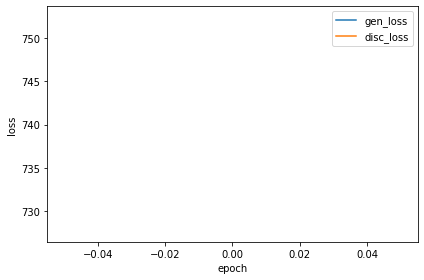

training epoch 2/50
encoder total loss:256.689
time epoch:1590.908s
saving the model...
encoder adversarial loss:711.005
discriminator loss:685.719


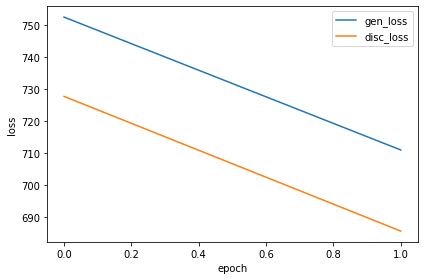

training epoch 3/50
encoder total loss:232.918
time epoch:1591.506s
saving the model...
encoder adversarial loss:686.132
discriminator loss:687.242


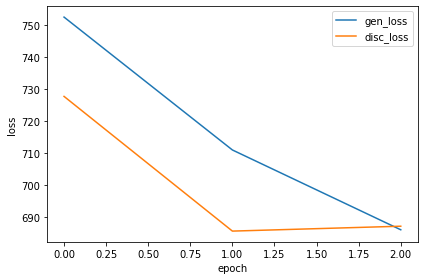

training epoch 4/50
encoder total loss:218.320
time epoch:1592.670s
saving the model...
encoder adversarial loss:673.069
discriminator loss:694.599


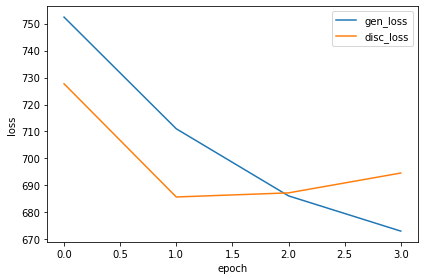

training epoch 5/50
encoder total loss:208.254
time epoch:1593.102s
saving the model...
encoder adversarial loss:671.287
discriminator loss:691.738


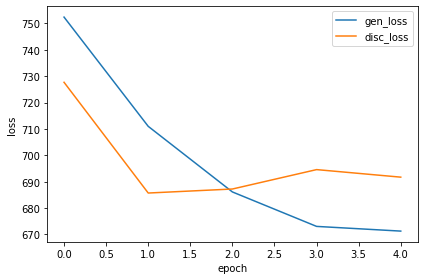

validation...
mse per frame:79.729
mae per frame:535.485
mse per pixel:0.006
mae per pixel:0.044
ssim:0.778
time:96.587s
----------------------------------------


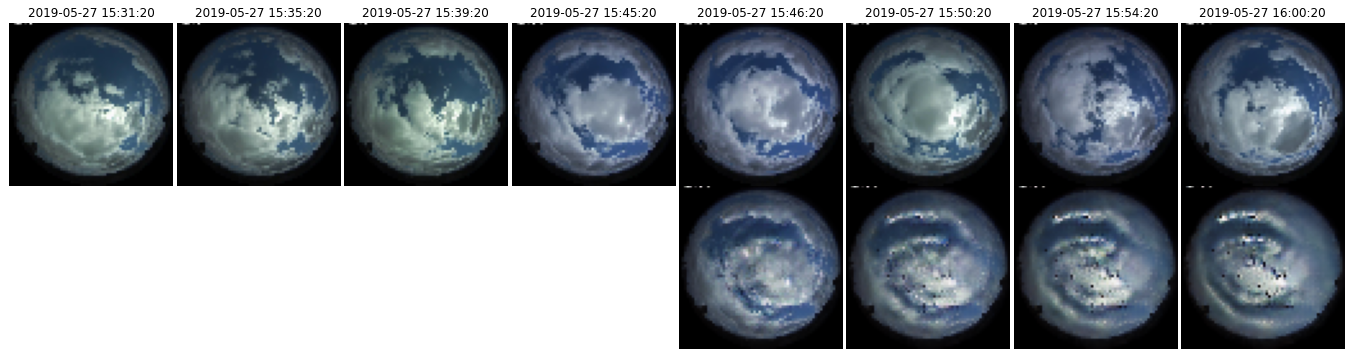

training epoch 6/50
encoder total loss:201.334
time epoch:1591.733s
saving the model...
encoder adversarial loss:670.054
discriminator loss:690.814


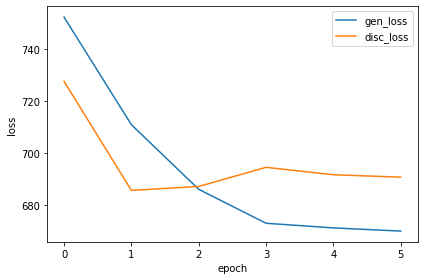

training epoch 7/50
encoder total loss:195.982
time epoch:1591.970s
saving the model...
encoder adversarial loss:663.037
discriminator loss:690.510


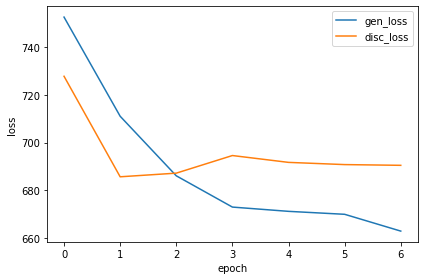

training epoch 8/50
encoder total loss:191.695
time epoch:1595.335s
saving the model...
encoder adversarial loss:661.582
discriminator loss:688.339


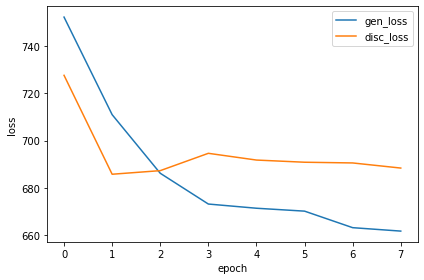

training epoch 9/50
encoder total loss:187.264
time epoch:1594.720s
saving the model...
encoder adversarial loss:656.189
discriminator loss:690.336


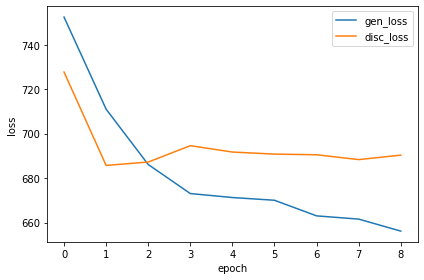

training epoch 10/50
encoder total loss:184.916
time epoch:1596.661s
saving the model...
encoder adversarial loss:653.600
discriminator loss:687.737


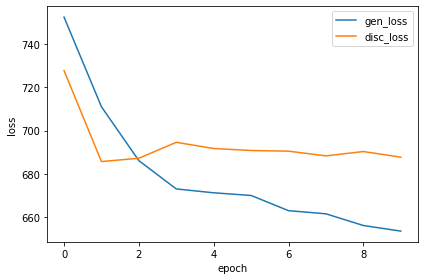

validation...
mse per frame:72.900
mae per frame:506.947
mse per pixel:0.006
mae per pixel:0.041
ssim:0.785
time:96.622s
----------------------------------------


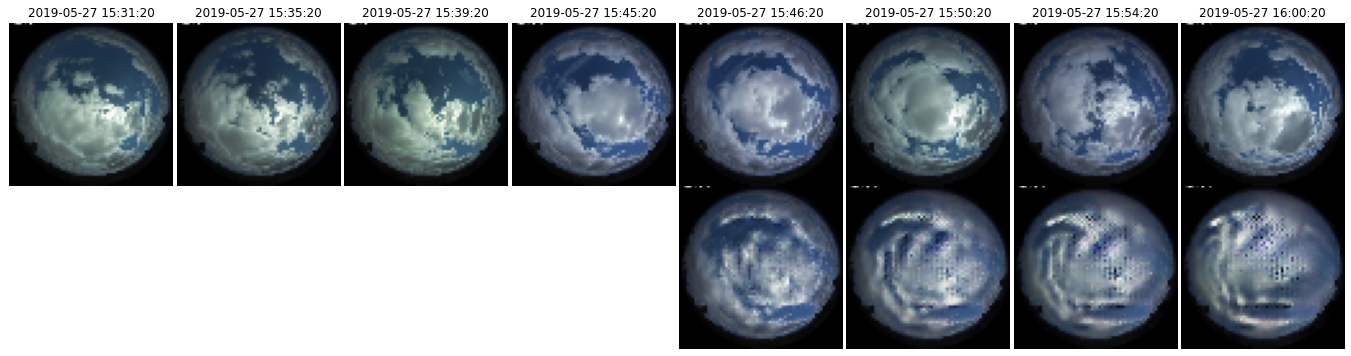

training epoch 11/50
encoder total loss:182.023
time epoch:1594.642s
saving the model...
encoder adversarial loss:643.845
discriminator loss:684.886


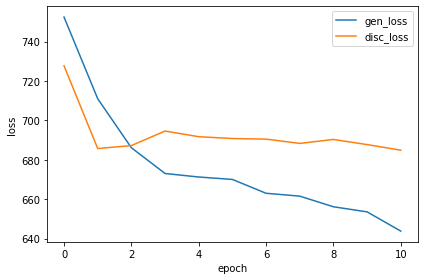

training epoch 12/50
encoder total loss:179.626
time epoch:1595.558s
saving the model...
encoder adversarial loss:639.778
discriminator loss:679.421


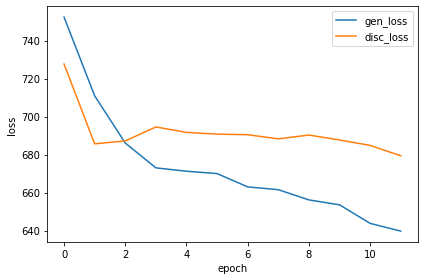

training epoch 13/50
encoder total loss:177.493
time epoch:1595.998s
saving the model...
encoder adversarial loss:627.821
discriminator loss:679.890


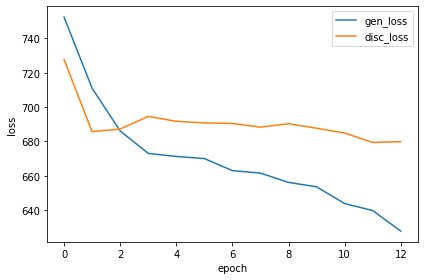

training epoch 14/50
encoder total loss:175.899
time epoch:1594.608s
saving the model...
encoder adversarial loss:625.593
discriminator loss:676.589


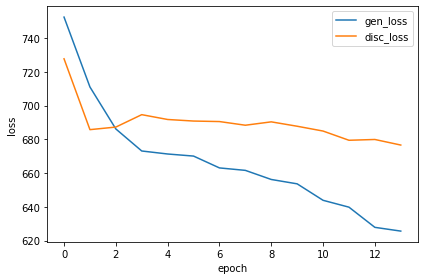

training epoch 15/50
encoder total loss:173.992
time epoch:1594.573s
saving the model...
encoder adversarial loss:615.539
discriminator loss:670.998


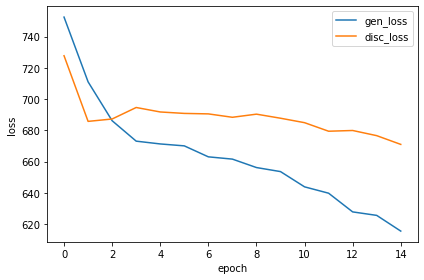

validation...
mse per frame:68.254
mae per frame:488.944
mse per pixel:0.006
mae per pixel:0.040
ssim:0.794
time:95.275s
----------------------------------------


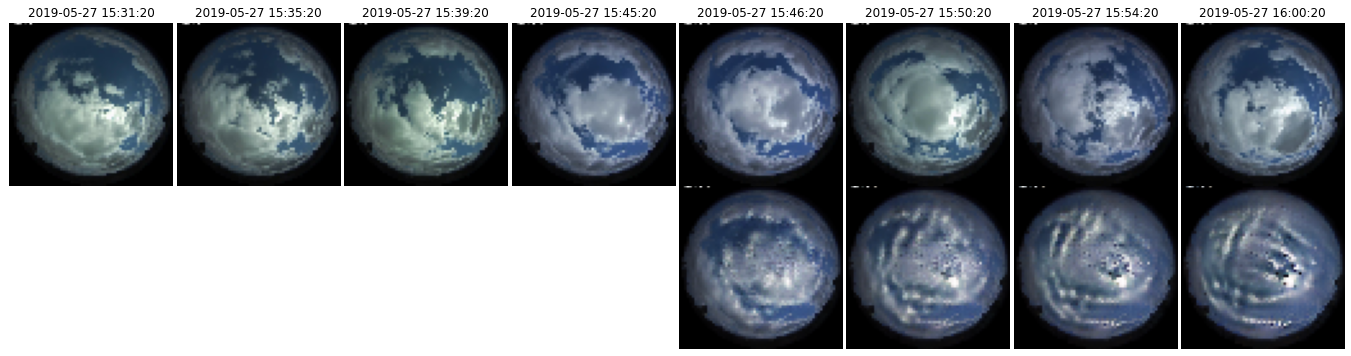

training epoch 16/50
encoder total loss:172.555
time epoch:1593.426s
saving the model...
encoder adversarial loss:621.330
discriminator loss:672.196


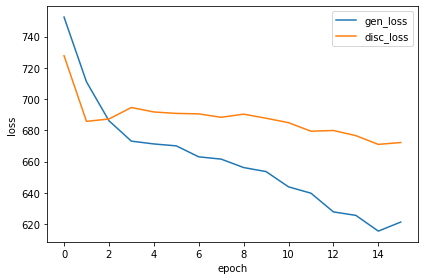

training epoch 17/50
encoder total loss:167.823
time epoch:1592.467s
saving the model...
encoder adversarial loss:638.893
discriminator loss:685.926


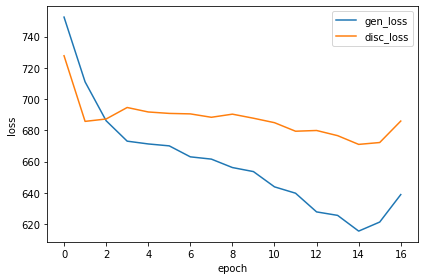

training epoch 18/50
encoder total loss:164.796
time epoch:1593.087s
saving the model...
encoder adversarial loss:645.181
discriminator loss:695.385


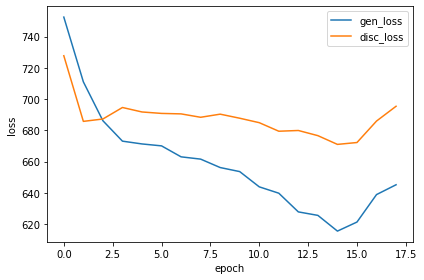

training epoch 19/50
encoder total loss:163.273
time epoch:1594.569s
saving the model...
encoder adversarial loss:655.318
discriminator loss:696.841


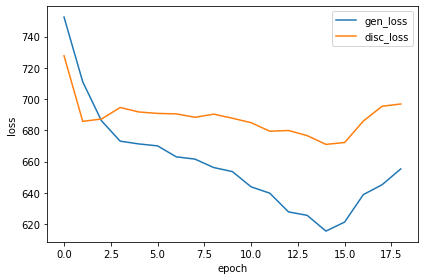

training epoch 20/50
encoder total loss:162.717
time epoch:1593.735s
saving the model...
encoder adversarial loss:661.454
discriminator loss:696.295


validation...
mse per frame:62.663
mae per frame:473.838
mse per pixel:0.005
mae per pixel:0.039
ssim:0.807
time:96.700s
----------------------------------------


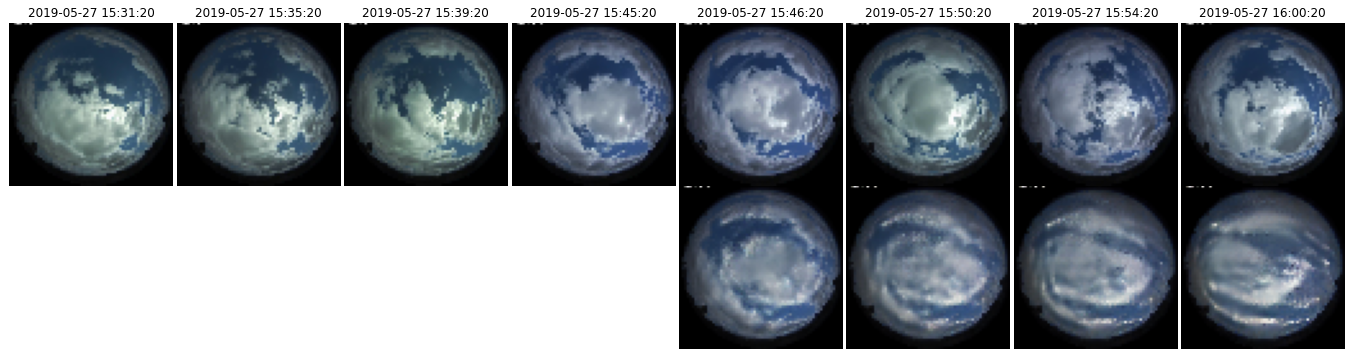

training epoch 21/50
encoder total loss:162.110
time epoch:1595.270s
saving the model...
encoder adversarial loss:671.839
discriminator loss:696.939


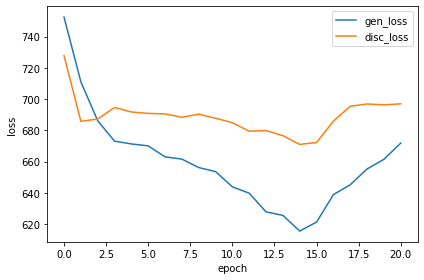

training epoch 22/50
encoder total loss:162.062
time epoch:1591.993s
saving the model...
encoder adversarial loss:679.534
discriminator loss:695.456


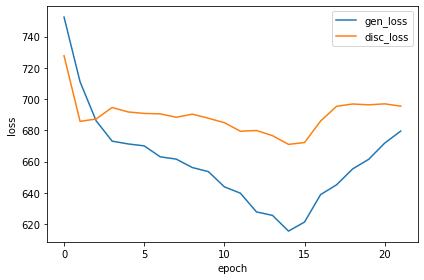

training epoch 23/50
encoder total loss:162.495
time epoch:1595.060s
saving the model...
encoder adversarial loss:689.196
discriminator loss:691.928


training epoch 24/50
encoder total loss:162.800
time epoch:1595.684s
saving the model...
encoder adversarial loss:698.848
discriminator loss:687.307


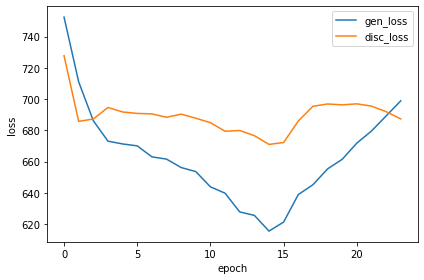

training epoch 25/50
encoder total loss:163.462
time epoch:1594.934s
saving the model...
encoder adversarial loss:702.589
discriminator loss:682.645


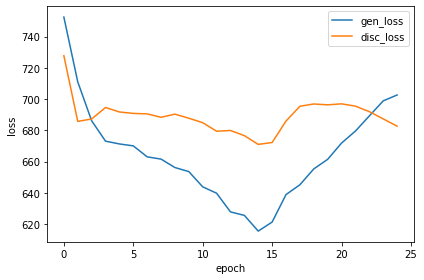

validation...
mse per frame:63.402
mae per frame:476.564
mse per pixel:0.005
mae per pixel:0.039
ssim:0.802
time:96.245s
----------------------------------------


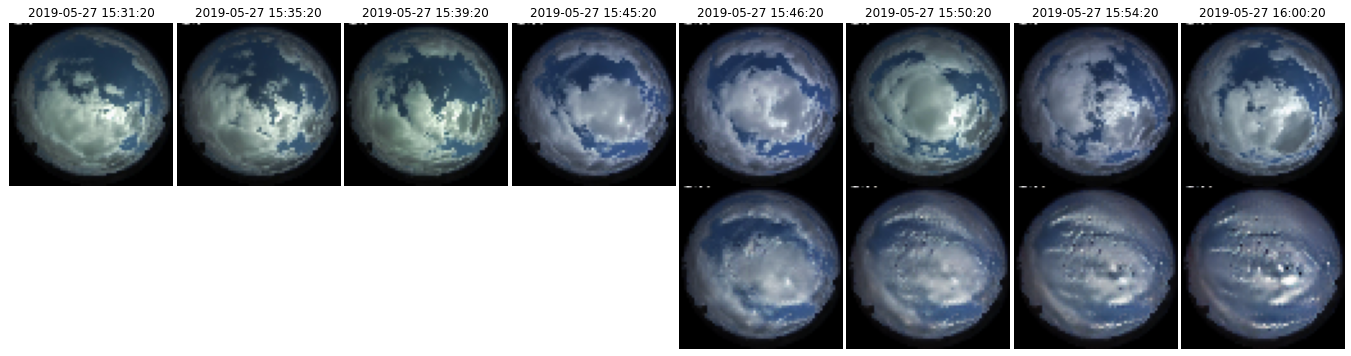

training epoch 26/50
encoder total loss:164.484
time epoch:1591.429s
saving the model...
encoder adversarial loss:715.849
discriminator loss:682.832


training epoch 27/50
encoder total loss:165.474
time epoch:1594.291s
saving the model...
encoder adversarial loss:723.213
discriminator loss:676.929


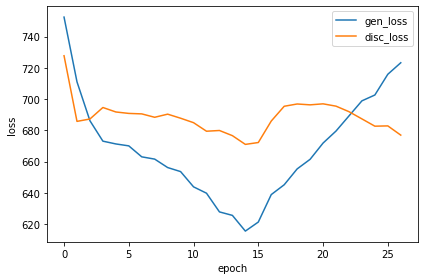

training epoch 28/50
encoder total loss:166.404
time epoch:1596.417s
saving the model...
encoder adversarial loss:733.538
discriminator loss:673.628


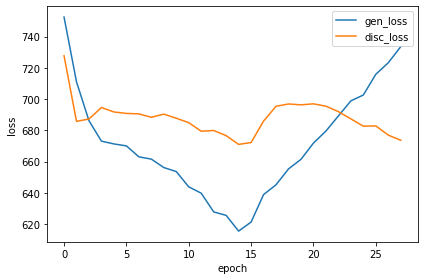

training epoch 29/50
encoder total loss:167.685
time epoch:1592.867s
saving the model...
encoder adversarial loss:743.211
discriminator loss:663.998


training epoch 30/50
encoder total loss:169.026
time epoch:1591.129s
saving the model...
encoder adversarial loss:748.698
discriminator loss:661.133


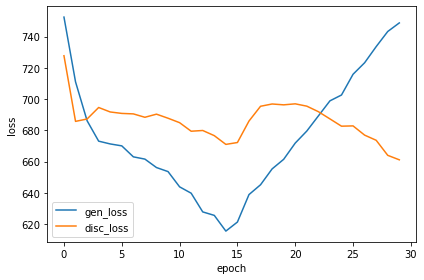

validation...
mse per frame:62.154
mae per frame:474.960
mse per pixel:0.005
mae per pixel:0.039
ssim:0.814
time:97.194s
----------------------------------------


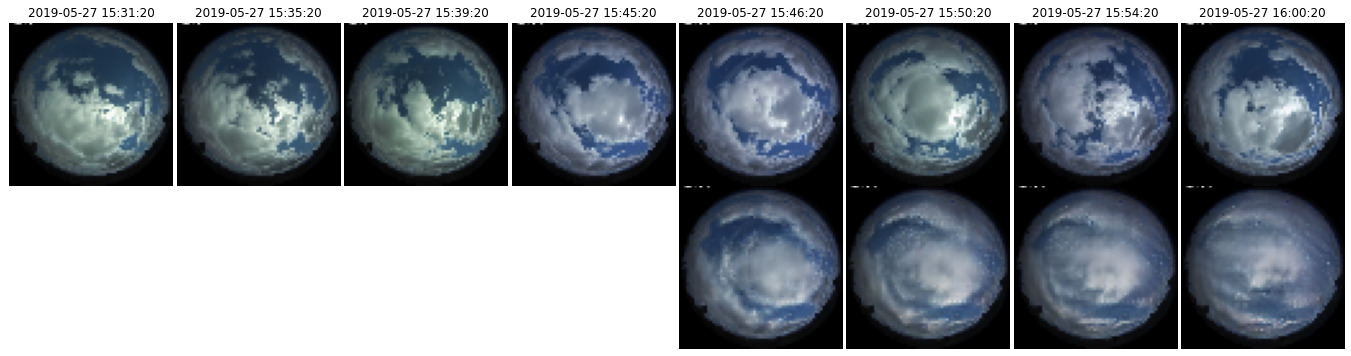

training epoch 31/50
encoder total loss:170.735
time epoch:1587.713s
saving the model...
encoder adversarial loss:753.010
discriminator loss:646.704


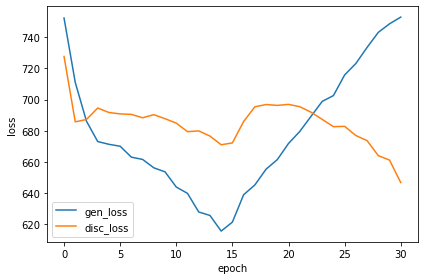

training epoch 32/50
encoder total loss:170.079
time epoch:1589.099s
saving the model...
encoder adversarial loss:749.004
discriminator loss:639.472


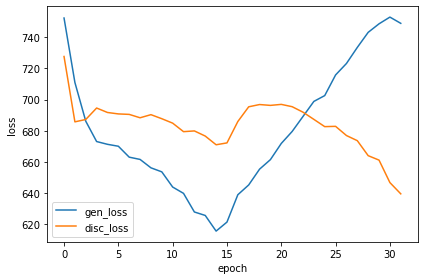

training epoch 33/50
encoder total loss:170.366
time epoch:1590.268s
saving the model...
encoder adversarial loss:746.826
discriminator loss:631.747


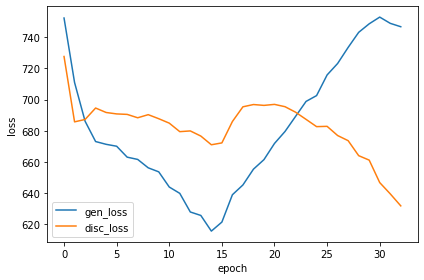

training epoch 34/50
encoder total loss:170.625
time epoch:1588.966s
saving the model...
encoder adversarial loss:754.508
discriminator loss:631.067


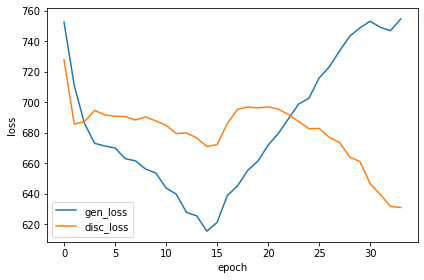

training epoch 35/50
encoder total loss:170.503
time epoch:1588.584s
saving the model...
encoder adversarial loss:748.614
discriminator loss:624.010


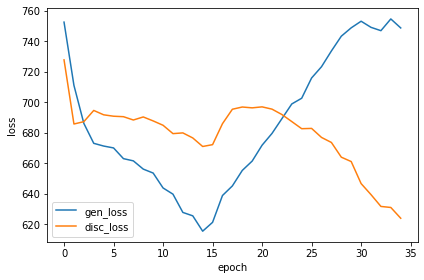

validation...
mse per frame:62.179
mae per frame:475.151
mse per pixel:0.005
mae per pixel:0.039
ssim:0.805
time:97.034s
----------------------------------------


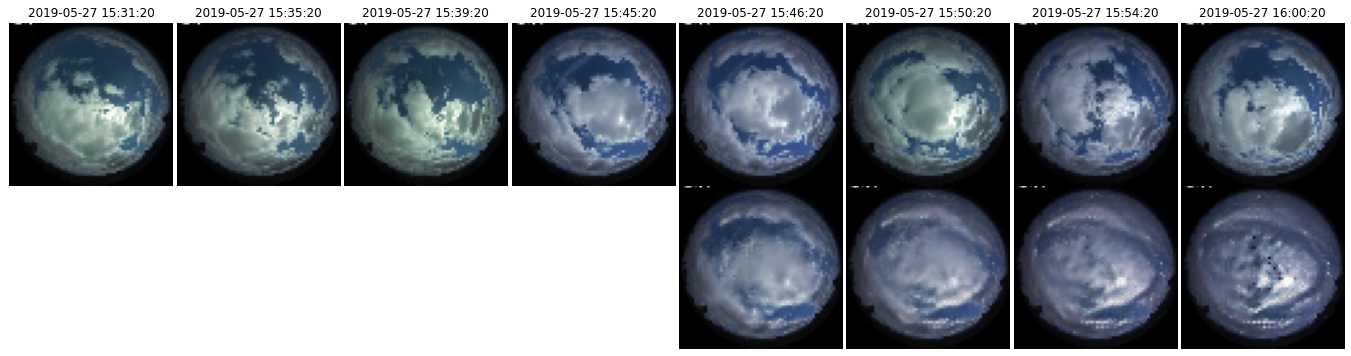

training epoch 36/50
encoder total loss:169.875
time epoch:1586.220s
saving the model...
encoder adversarial loss:751.264
discriminator loss:624.237


training epoch 37/50
encoder total loss:169.150
time epoch:1587.716s
saving the model...
encoder adversarial loss:746.951
discriminator loss:623.260


training epoch 38/50
encoder total loss:169.043
time epoch:1586.133s
saving the model...
encoder adversarial loss:740.496
discriminator loss:620.110


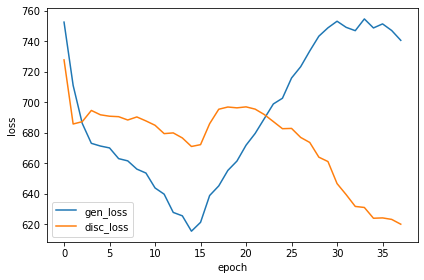

training epoch 39/50
encoder total loss:168.767
time epoch:1588.967s
saving the model...
encoder adversarial loss:749.016
discriminator loss:623.785


training epoch 40/50
encoder total loss:169.606
time epoch:1590.638s
saving the model...
encoder adversarial loss:759.758
discriminator loss:613.800


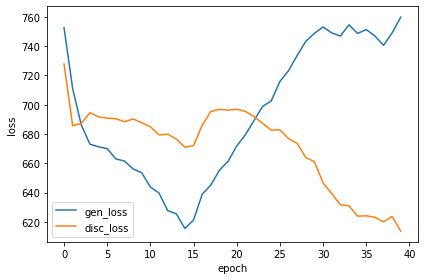

validation...
mse per frame:63.983
mae per frame:488.492
mse per pixel:0.005
mae per pixel:0.040
ssim:0.805
time:96.842s
----------------------------------------


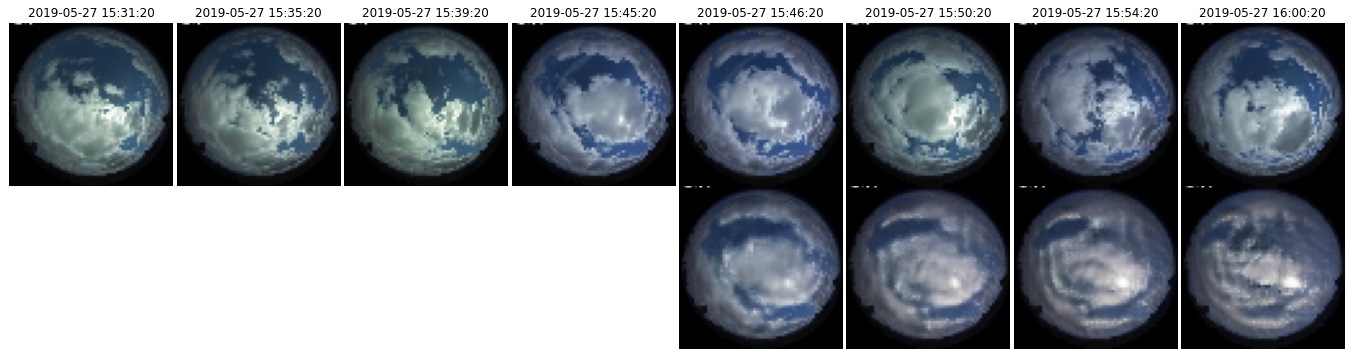

training epoch 41/50
encoder total loss:170.745
time epoch:1590.976s
saving the model...
encoder adversarial loss:760.405
discriminator loss:608.059


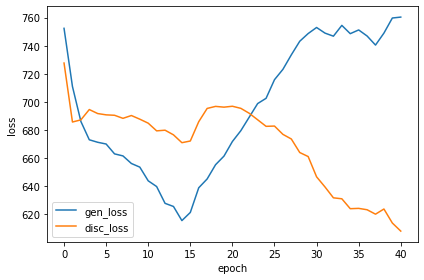

training epoch 42/50
encoder total loss:170.872
time epoch:1591.833s
saving the model...
encoder adversarial loss:769.834
discriminator loss:609.503


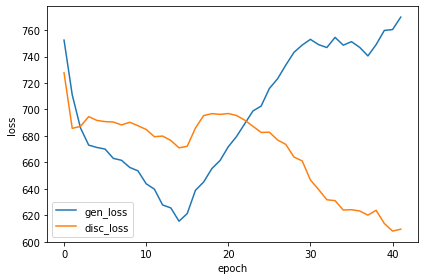

training epoch 43/50
encoder total loss:170.918
time epoch:1593.513s
saving the model...
encoder adversarial loss:779.998
discriminator loss:608.439


training epoch 44/50
encoder total loss:170.426
time epoch:1596.663s
saving the model...
encoder adversarial loss:769.555
discriminator loss:611.306


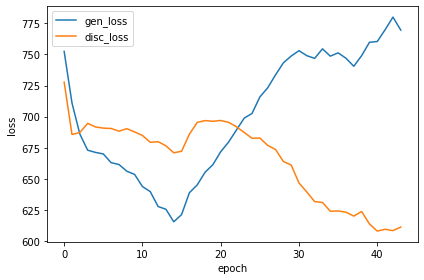

training epoch 45/50
encoder total loss:170.500
time epoch:1596.028s
saving the model...
encoder adversarial loss:771.372
discriminator loss:605.926


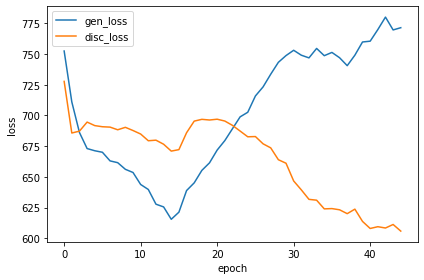

validation...
mse per frame:59.090
mae per frame:467.050
mse per pixel:0.005
mae per pixel:0.038
ssim:0.814
time:96.314s
----------------------------------------


training epoch 46/50
encoder total loss:171.095
time epoch:1595.276s
saving the model...
encoder adversarial loss:783.584
discriminator loss:605.478


training epoch 47/50
encoder total loss:170.085
time epoch:1592.622s
saving the model...
encoder adversarial loss:781.764
discriminator loss:608.089


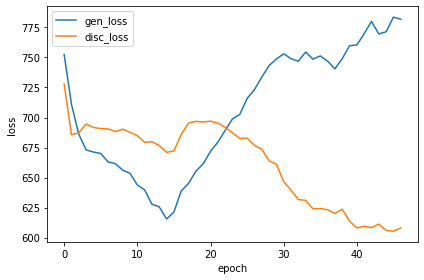

training epoch 48/50
encoder total loss:171.973
time epoch:1595.280s
saving the model...
encoder adversarial loss:805.655
discriminator loss:592.277


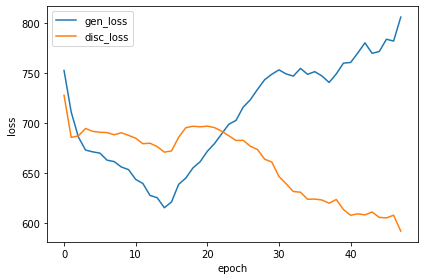

training epoch 49/50
encoder total loss:173.017
time epoch:1595.684s
saving the model...
encoder adversarial loss:824.141
discriminator loss:592.364


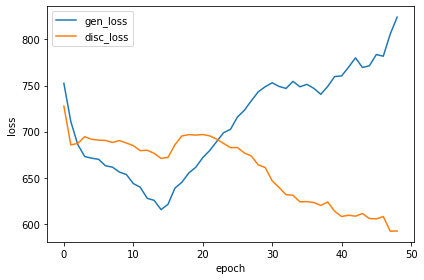

training epoch 50/50
encoder total loss:171.579
time epoch:1597.351s
saving the model...
encoder adversarial loss:817.207
discriminator loss:597.919


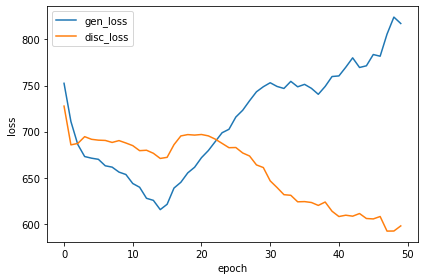

validation...
mse per frame:59.309
mae per frame:464.588
mse per pixel:0.005
mae per pixel:0.038
ssim:0.816
time:97.401s
----------------------------------------


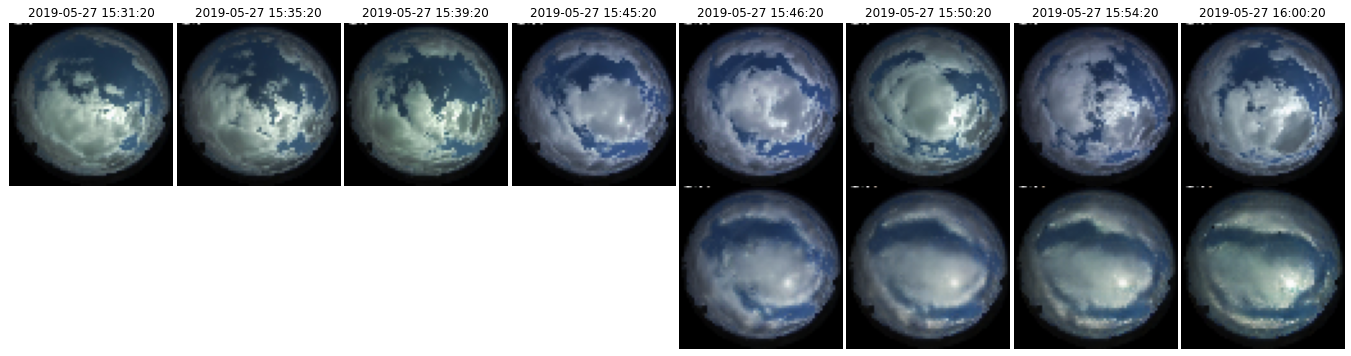

In [35]:
encoder_total_train_losses,encoder_ad_train_losses,discr_train_losses = trainIters(encoder,discriminator_frame,nepochs,print_every=print_every,eval_every=eval_every,name=save_name)

In [ ]:
# the model training was disrupted so we load the trained model and resume training

encoder.load_state_dict(torch.load('save/{0}/encoder.pth'.format(save_name)))
encoder.train()

In [17]:
discriminator_frame.load_state_dict(torch.load('save/{0}/discriminator.pth'.format(save_name)))
discriminator_frame.train()

Discr_frame(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (14): Flatten(start_dim=1, end_dim

In [18]:
def train_on_batch(epoch, input_tensor, target_tensor, encoder, encoder_optimizer, criterion_mae, criterion_mse, discr_frame, discr_frame_optimizer):                
    
    encoder_optimizer.zero_grad()
    
    # input_tensor : torch.Size([batch_size, input_length, channels, cols, rows])
    curr_batch_size = input_tensor.size(0)    
    input_length  = input_tensor.size(1)
    target_length = target_tensor.size(1)
    loss = 0
    encoder_frame_ad_loss = 0
    real_label = torch.full((curr_batch_size,), 1, dtype=torch.float, device=device)
    fake_label = torch.full((curr_batch_size,), 1, dtype=torch.float, device=device)
    discr_frame_loss = 0
    r_eta,real_input_flag_encoder = reserve_schedule_sampling_exp(epoch,input_length)
    eta,real_input_flag_decoder = schedule_sampling(epoch,target_length)
    
    encoder_input = input_tensor[:,0,:,:,:]
    for ei in range(input_length-1): 
        encoder_output, encoder_hidden, encoder_output_image,_,_ = encoder(encoder_input, (ei==0))
        encoder_target = input_tensor[:,ei+1,:,:,:]
        loss += criterion_mae(encoder_output_image,encoder_target)
        
        if real_input_flag_encoder[ei]:
            encoder_input = encoder_target # Teacher forcing    
        else:
            encoder_input = encoder_output_image
    
    if real_input_flag_encoder[-1]:        
        decoder_input = input_tensor[:,-1,:,:,:] 
    else:
        decoder_input = encoder_output_image # first decoder input = last image of input sequence
    
    for di in range(target_length):
        decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input)
        target = target_tensor[:,di,:,:,:]
        loss += criterion_mae(output_image,target)
        if (epoch+1)%training_discriminator_every==0:
            discr_frame_out_fake = discr_frame(output_image).view(-1)
            encoder_frame_ad_loss += 0.5 * torch.mean((discr_frame_out_fake - 1)**2)
        
        if real_input_flag_decoder[di]:
            decoder_input = target # Teacher forcing    
        else:
            decoder_input = output_image
    
    if (epoch+1)%training_discriminator_every==0:
        loss += lamda*encoder_frame_ad_loss
    
    # Moment regularization  # encoder.phycell.cell_list[0].F.conv1.weight # size (nb_filters,in_channels,7,7)
    k2m = K2M([7,7]).to(device)
    for b in range(0,encoder.phycell.cell_list[0].input_dim):
        filters = encoder.phycell.cell_list[0].F.conv1.weight[:,b,:,:] # (nb_filters,7,7)     
        m = k2m(filters.double()) 
        m  = m.float()   
        loss += criterion_mse(m, constraints) # constrains is a precomputed matrix   
    loss.backward()
    encoder_optimizer.step()
    
    if (epoch+1)%training_discriminator_every==0:
        discr_frame_optimizer.zero_grad()
        if real_input_flag_encoder[-1]:        
            decoder_input = input_tensor[:,-1,:,:,:] 
        else:
            decoder_input = encoder_output_image # first decoder input = last image of input sequence
        for di in range(target_length):
            decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input)
            target = target_tensor[:,di,:,:,:]
            discr_frame_out_real = discr_frame(target).view(-1)
            discr_frame_out_fake = discr_frame(output_image.detach()).view(-1)
            discr_frame_loss += 0.5 * (torch.mean((discr_frame_out_real - 1)**2) + torch.mean(discr_frame_out_fake**2))

            if real_input_flag_decoder[di]:
                decoder_input = target # Teacher forcing    
            else:
                decoder_input = output_image

        discr_frame_loss.backward()
        discr_frame_optimizer.step()
        
        return discr_frame_loss.item()/target_length, encoder_frame_ad_loss.item()/target_length, loss.item() / target_length
    
    else:
        return discr_frame_loss/target_length, encoder_frame_ad_loss/target_length, loss.item() / target_length

def trainIters(encoder, discr_frame, nepochs, print_every=10,eval_every=10,name=''):
    encoder_total_train_losses = []
    encoder_ad_train_losses = []
    discr_train_losses = []
    #real_acc_hist = []
    #fake_acc_hist = []
    #overall_acc_hist = []
    best_mse = float('inf')

    encoder_optimizer = torch.optim.Adam(encoder.parameters(),lr=0.001,betas=(0.5,0.99))
    discr_frame_optimizer = torch.optim.Adam(discr_frame.parameters(),lr=0.0002,betas=(0.5,0.99))
    scheduler_enc = ReduceLROnPlateau(encoder_optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    scheduler_discr = ReduceLROnPlateau(discr_frame_optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    criterion_mae = nn.L1Loss()
    criterion_mse = nn.MSELoss()
    
    for epoch in range(31, nepochs):
        t0 = time.time()
        encoder_total_loss_epoch = 0
        discr_loss_epoch = 0
        encoder_ad_loss_epoch = 0
        #real_acc_epoch = 0
        #fake_acc_epoch = 0
        #overall_acc_epoch = 0
        #teacher_forcing_ratio = np.maximum(0 , 1 - epoch * 0.003)
        
        for i, out in enumerate(train_loader, 0):
            input_tensor = out[1].to(device)
            target_tensor = out[2].to(device)
            discr_frame_loss, encoder_frame_ad_loss, loss = train_on_batch(epoch, input_tensor, target_tensor, encoder, encoder_optimizer, criterion_mae, criterion_mse, discr_frame, discr_frame_optimizer)                                   
            encoder_total_loss_epoch += loss
            discr_loss_epoch += discr_frame_loss
            encoder_ad_loss_epoch += encoder_frame_ad_loss
            #real_acc_epoch += real_acc
            #fake_acc_epoch += fake_acc
                      
        #overall_acc_epoch = real_acc_epoch+fake_acc_epoch
        #real_acc_epoch /= len(times_curr_train)
        #fake_acc_epoch /= len(times_curr_train)
        #overall_acc_epoch /= (2*len(times_curr_train))
        encoder_total_train_losses.append(encoder_total_loss_epoch)     
        encoder_ad_train_losses.append(encoder_ad_loss_epoch)
        discr_train_losses.append(discr_loss_epoch)
        #real_acc_hist.append(real_acc_epoch)
        #fake_acc_hist.append(fake_acc_epoch)
        #overall_acc_hist.append(overall_acc_epoch)
        
        if (epoch+1) % print_every == 0:
            print('training epoch {0}/{1}'.format(epoch+1,nepochs))
            print('encoder total loss:{0:.3f}'.format(encoder_total_loss_epoch))
            print('time epoch:{0:.3f}s'.format(time.time()-t0))
            
        if (epoch+1) % save_model_every == 0:
            print('saving the model...')
            torch.save(encoder.state_dict(),'save/{0}/encoder.pth'.format(name))
            torch.save(discr_frame.state_dict(),'save/{0}/discriminator.pth'.format(name))
            
        if (epoch+1) % training_discriminator_every == 0:  
            print('encoder adversarial loss:{0:.3f}'.format(encoder_ad_loss_epoch))
            print('discriminator loss:{0:.3f}'.format(discr_loss_epoch)) 
            #print('discriminator acc. (real):{0:.3f}'.format(real_acc_epoch))
            #print('discriminator acc. (fake):{0:.3f}'.format(fake_acc_epoch))
            #print('discriminator acc. (overall):{0:.3f}'.format(overall_acc_epoch))
            #f,ax=plt.subplots(1,2)
            f,ax=plt.subplots()
            #f.set_size_inches((8,4))
            ax.plot(range(len(encoder_ad_train_losses)),encoder_ad_train_losses,label="gen_loss")
            ax.plot(range(len(discr_train_losses)),discr_train_losses,label='disc_loss')
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            ax.legend()
            #ax[1].plot(range(len(real_acc_hist)),real_acc_hist,label="real_acc")
            #ax[1].plot(range(len(fake_acc_hist)),fake_acc_hist,label="fake_acc")
            #ax[1].plot(range(len(overall_acc_hist)),overall_acc_hist,label="overall_acc")
            #ax[1].set_xlabel('epoch')
            #ax[1].set_ylabel('accuracy')
            #ax[1].legend()
            f.tight_layout()
            plt.show()
            
        if (epoch+1) % eval_every == 0:
            mse,mae,ssim,predictions,_ = evaluate(encoder,test_loader)
            scheduler_enc.step(mae)
            scheduler_discr.step(mae)
        if (epoch+1) % plot_every == 0:
            select_idx = [1144,776,1203,3867]
            plot_gen_images(predictions,times_curr_val,images_log_val,images_pred_val,select_idx)
        
    return encoder_total_train_losses,encoder_ad_train_losses,discr_train_losses

def evaluate(encoder,loader):
    total_mse, total_mae,total_ssim = 0,0,0
    t0 = time.time()
    predictions = []
    indices = []
    with torch.no_grad():
        for i, out in enumerate(loader, 0):
            indices.append(out[0])
            input_tensor = out[1].to(device)
            target_tensor = out[2].to(device)
            input_length = input_tensor.size()[1]
            target_length = target_tensor.size()[1]

            for ei in range(input_length-1):
                encoder_output, encoder_hidden, _,_,_  = encoder(input_tensor[:,ei,:,:,:], (ei==0))

            decoder_input = input_tensor[:,-1,:,:,:] # first decoder input= last image of input sequence
            prediction = []
            
            for di in range(target_length):
                decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input, False, False)
                decoder_input = output_image
                prediction.append(output_image.cpu())
            
            input = input_tensor.cpu().numpy()
            target = target_tensor.cpu().numpy()
            prediction =  np.stack(prediction) # (8, batch_size, 3, 64, 64)
            prediction = prediction.swapaxes(0,1)  # (batch_size, 8, 3, 64, 64)
            #print(prediction.shape)
            
            mse_batch = np.mean((prediction-target)**2 , axis=1).sum()
            mae_batch = np.mean(np.abs(prediction-target) ,  axis=1).sum() 
            total_mse += mse_batch
            total_mae += mae_batch
            
            for a in range(0,target.shape[0]):
                for b in range(0,target.shape[1]):
                    total_ssim += ssim(np.transpose(target[a,b],(1,2,0)), np.transpose(prediction[a,b],(1,2,0)), multichannel=True) 

            #cross_entropy = -target*np.log(prediction) - (1-target) * np.log(1-prediction)
            #cross_entropy = cross_entropy.sum()
            #cross_entropy = cross_entropy / (args.batch_size*target_length)
            #cross_entropy = cross_entropy / (batch_size*target_length)
            #total_bce +=  cross_entropy
            predictions.append(prediction)
    
    predictions =  np.concatenate(predictions,axis=0) # (10, batch_size, 1, 64, 64)
    #predictions = predictions.swapaxes(0,1)  # (batch_size,10, 1, 64, 64)
    print("validation...")    
    print('mse per frame:{0:.3f}'.format(total_mse/len(times_curr_val)))  
    print('mae per frame:{0:.3f}'.format(total_mae/len(times_curr_val)))
    print('mse per pixel:{0:.3f}'.format(total_mse/len(times_curr_val)/(img_side_len*img_side_len*num_color_channel)))  
    print('mae per pixel:{0:.3f}'.format(total_mae/len(times_curr_val)/(img_side_len*img_side_len*num_color_channel)))
    print('ssim:{0:.3f}'.format(total_ssim/len(times_curr_val)/target_length))
    print('time:{0:.3f}s'.format(time.time()-t0))
    print('-'*40)
    return total_mse/len(times_curr_val),  total_mae/len(times_curr_val), total_ssim/len(times_curr_val)/target_length, predictions, indices

### Evaluation

In [17]:
data_set = SkyImageDataset([images_log_test, images_pred_test])
test_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [18]:
encoder.load_state_dict(torch.load('save/{0}/encoder.pth'.format(save_name)))
encoder.eval()
mse, mae, SSIM, predictions, indices = evaluate(encoder,test_loader)

validation...
mse per frame:59.309
mae per frame:464.588
mse per pixel:0.005
mae per pixel:0.038
ssim:0.816
time:96.531s
----------------------------------------


In [19]:
print(predictions.shape)
predictions = predictions.transpose((0,1,3,4,2))
print(predictions.shape)

(4467, 8, 3, 64, 64)
(4467, 8, 64, 64, 3)


In [67]:
np.save('save/{0}/predicted_images.npy'.format(save_name), predictions)

In [63]:
random.seed(0)
select_num_samples = 30
select_idx = random.sample(np.arange(len(times_curr_test)).tolist(),select_num_samples)
select_idx

[3155,
 3445,
 331,
 2121,
 4188,
 3980,
 3317,
 2484,
 3904,
 2933,
 1789,
 4134,
 1140,
 2308,
 1144,
 776,
 2052,
 4362,
 1203,
 2540,
 809,
 604,
 2704,
 3867,
 824,
 2898,
 3556,
 2590,
 1675,
 3907]

In [65]:
select_idx = [2484]

-------------------------------------------------- sample  1 --------------------------------------------------


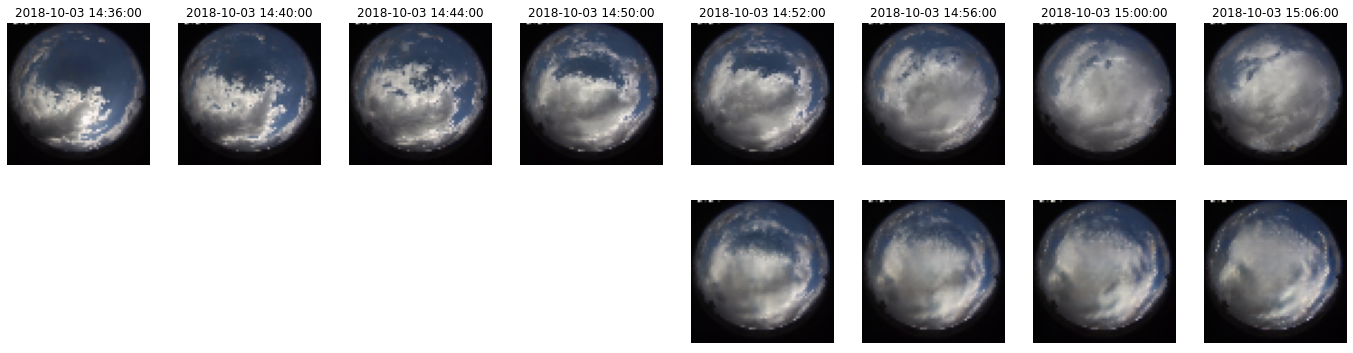

-------------------------------------------------- sample  2 --------------------------------------------------


IndexError: list index out of range

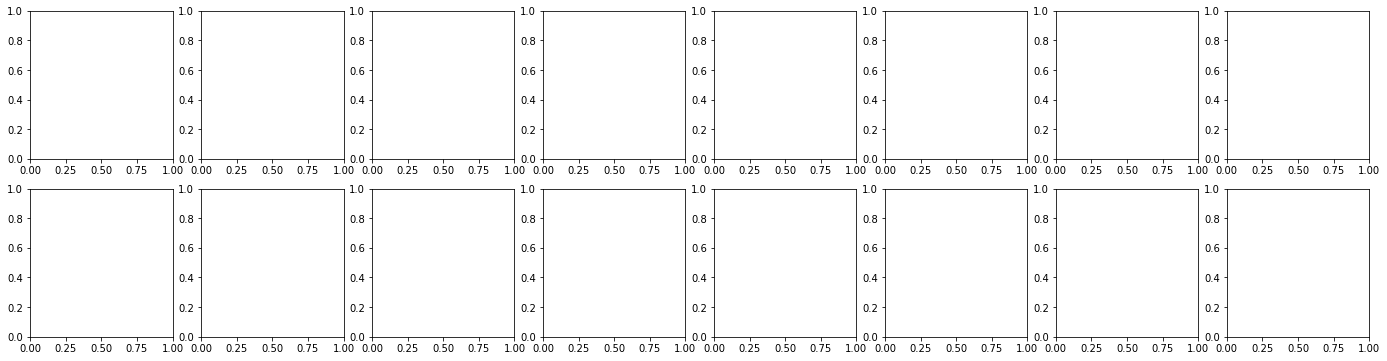

In [66]:
for i in range(select_num_samples):
    print("-"*50,"sample ",str(i+1), "-"*50)
    f, ax = plt.subplots(2,8)
    f.set_size_inches(24,6)
    ax[0,0].imshow(images_log_test[select_idx[i]][0][:,:,::-1])
    ax[0,0].set_title(times_curr_test[select_idx[i]]-datetime.timedelta(minutes=15))
    ax[0,1].imshow(images_log_test[select_idx[i]][2][:,:,::-1])
    ax[0,1].set_title(times_curr_test[select_idx[i]]-datetime.timedelta(minutes=11))
    ax[0,2].imshow(images_log_test[select_idx[i]][4][:,:,::-1])
    ax[0,2].set_title(times_curr_test[select_idx[i]]-datetime.timedelta(minutes=7))
    ax[0,3].imshow(images_log_test[select_idx[i]][7][:,:,::-1])
    ax[0,3].set_title(times_curr_test[select_idx[i]]-datetime.timedelta(minutes=1))
    ax[0,4].imshow(images_pred_test[select_idx[i]][0][:,:,::-1])
    ax[0,4].set_title(times_curr_test[select_idx[i]]+datetime.timedelta(minutes=1))
    ax[0,5].imshow(images_pred_test[select_idx[i]][2][:,:,::-1])
    ax[0,5].set_title(times_curr_test[select_idx[i]]+datetime.timedelta(minutes=5))
    ax[0,6].imshow(images_pred_test[select_idx[i]][4][:,:,::-1])
    ax[0,6].set_title(times_curr_test[select_idx[i]]+datetime.timedelta(minutes=9))
    ax[0,7].imshow(images_pred_test[select_idx[i]][7][:,:,::-1])
    ax[0,7].set_title(times_curr_test[select_idx[i]]+datetime.timedelta(minutes=15))
    
    ax[1,4].imshow(predictions[select_idx[i]][0][:,:,::-1])
    ax[1,5].imshow(predictions[select_idx[i]][2][:,:,::-1])
    ax[1,6].imshow(predictions[select_idx[i]][4][:,:,::-1])
    ax[1,7].imshow(predictions[select_idx[i]][7][:,:,::-1])
    
    ax[0,0].axis('off')
    ax[0,1].axis('off')
    ax[0,2].axis('off')
    ax[0,3].axis('off')
    ax[0,4].axis('off')
    ax[0,5].axis('off')
    ax[0,6].axis('off')
    ax[0,7].axis('off')
    ax[1,0].axis('off')
    ax[1,1].axis('off')
    ax[1,2].axis('off')
    ax[1,3].axis('off')
    ax[1,4].axis('off')
    ax[1,5].axis('off')
    ax[1,6].axis('off')
    ax[1,7].axis('off')
    
    plt.show()